In [4]:
from manim import *
import jupyter_capture_output

video_scene = " -v WARNING  --disable_caching ndw_bernoulli_Scene"
image_scene = f" -v WARNING --disable_caching -r {2*427},{2*240}  -s ndw_bernoulli_Scene"

In [61]:
background_color = "#20455A"

In [ ]:
class BernoulliTube(Mobject):
    def __init__(self, tube_center = np.array([-2, -1.5, 0]), tube_stroke_color = WHITE, **kwargs):
        super().__init__(**kwargs)

        self.center = tube_center
        self.tube_height = 1.5
        self.tube_width = 5
        self.tube_line_width = 5
        self.tube_stroke_color = tube_stroke_color

        # define main drift tube coordinates
        self.up_left = self.center + self.tube_height*UP + self.tube_width/2*LEFT
        self.up_mid_left = self.center + self.tube_height*UP + self.tube_width/10*LEFT
        self.up_mid_right = self.center + self.tube_height/4*UP + self.tube_width/10*RIGHT
        self.up_right = self.center + self.tube_height/4*UP + self.tube_width/2*RIGHT

        self.down_left = self.center + self.tube_height*DOWN + self.tube_width/2*LEFT
        self.down_mid_left = self.center + self.tube_height*DOWN + self.tube_width/10*LEFT
        self.down_mid_right = self.center + self.tube_height/4*DOWN + self.tube_width/10*RIGHT
        self.down_right = self.center + self.tube_height/4*DOWN + self.tube_width/2*RIGHT

        # bernoulli tube main lines
        tube_tunnel_up = Line(start = self.up_mid_right, end = self.up_right, stroke_color = self.tube_stroke_color, stroke_width = self.tube_line_width)
        tube_tunnel_down = Line(start = self.down_mid_right, end = self.down_right, stroke_color = self.tube_stroke_color, stroke_width = self.tube_line_width)
        tube_funnel_up = Line(start = self.up_mid_left, end = self.up_mid_right, stroke_color = self.tube_stroke_color, stroke_width = self.tube_line_width)
        tube_funnel_down = Line(start = self.down_mid_left, end = self.down_mid_right, stroke_color = self.tube_stroke_color, stroke_width = self.tube_line_width)
        tube_tunnel_up_left = Line(start = self.up_mid_left, end = self.up_left, stroke_color = self.tube_stroke_color, stroke_width = self.tube_line_width)
        tube_tunnel_down_left = Line(start = self.down_mid_left, end = self.down_left, stroke_color = self.tube_stroke_color, stroke_width = self.tube_line_width)

        # bernoulli tube background
        polygon_corner_list = [
            self.up_left,
            self.up_mid_left,
            self.up_mid_right,
            self.up_right,
            self.down_right,
            self.down_mid_right,
            self.down_mid_left,
            self.down_left
        ]
        tube_background_polygon = Polygon(*polygon_corner_list, fill_color = WHITE, fill_opacity = 1, stroke_opacity = 0, stroke_width = self.tube_line_width)
        tube_polygon = Polygon(*polygon_corner_list, fill_color = BLUE, fill_opacity = 0.25, stroke_opacity = 0, stroke_width = self.tube_line_width)

        # counter threshold
        counter_line = DashedLine(start = self.up_mid_right + self.tube_width/5*RIGHT, end = self.down_mid_right + self.tube_width/5*RIGHT, color = self.tube_stroke_color)
        self.add(tube_background_polygon, tube_polygon)
        self.add(tube_tunnel_up, tube_tunnel_down, tube_funnel_up, tube_funnel_down, tube_tunnel_up_left, tube_tunnel_down_left, counter_line)

        # coordinate system
        self.tube_ax = Axes(x_range = [0, self.tube_width, 1], y_range = [-1, 1, 1], x_length = self.tube_width, y_length = 2*self.tube_height).set_color(BLACK).move_to(self.center)
        self.add(self.tube_ax)


    # calculate the cross section depending on the x coordinate
    def get_cross_section(self, x):
        if x < 2/5*self.tube_width:
            return (2*self.tube_height)**2 * PI
        elif x > 2/5*self.tube_width and x < 3/5*self.tube_width:
            return (self.tube_height/4 * (10 - 15*x/self.tube_width))**2 * PI
        else:
            return (self.tube_height/2)**2 * PI
        


    # returns a trajectory function for a given starting y-position and a given starting time
    def get_trajectory(self, y0, t0):
        # trajectory function
        def trajectory(t):
            return
        return trajectory


    # trajectory of a fluid particle with t in [0, 1] and starting height
    def bernoulli_tube_trajectory(t):
        return
            

    def get_counter(self, n = 0):
        counter_bg = Rectangle(height = 1, width = self.tube_width/5*2, stroke_color = WHITE, stroke_opacity = 0, fill_opacity = 0.95).move_to(self.center + 1.5/5*self.tube_width*RIGHT + 3*UP)
        counter_number = Text(f"{n}", color = BLACK).move_to(self.center + 1.5/5*self.tube_width*RIGHT + 3*UP)
        counter_bg.z_index = -1
        return VGroup(counter_bg, counter_number)


class DoorHallway(Mobject):
    def __init__(self, hallway_center = np.array([2, -1.5, 0]), **kwargs):
        super().__init__(**kwargs)

        self.center = hallway_center
        tube_height = 1
        tube_width = 2
        tube_line_width = 4
        tube_color = WHITE

        # define main drift tube coordinates
        self.up_left = self.center + tube_height*UP + tube_width*2*LEFT
        self.up_mid_left = self.center + tube_height*UP + tube_width*LEFT
        self.up_mid_right = self.center + tube_height/4*UP + tube_width/2*LEFT
        self.up_right = self.center + tube_height/4*UP + tube_width/2*RIGHT

        self.down_left = self.center + tube_height*DOWN + tube_width*2*LEFT
        self.down_mid_left = self.center + tube_height*DOWN + tube_width*LEFT
        self.down_mid_right = self.center + tube_height/4*DOWN + tube_width/2*LEFT
        self.down_right = self.center + tube_height/4*DOWN + tube_width/2*RIGHT

        # bernoulli tube main lines
        tube_tunnel_up = Line(start = self.up_mid_right, end = self.up_right, stroke_color = tube_color, stroke_width = tube_line_width)
        tube_tunnel_down = Line(start = self.down_mid_right, end = self.down_right, stroke_color = tube_color, stroke_width = tube_line_width)
        tube_funnel_up = Line(start = self.up_mid_left, end = self.up_mid_right, stroke_color = tube_color, stroke_width = tube_line_width)
        tube_funnel_down = Line(start = self.down_mid_left, end = self.down_mid_right, stroke_color = tube_color, stroke_width = tube_line_width)
        tube_tunnel_up_left = Line(start = self.up_mid_left, end = self.up_left, stroke_color = tube_color, stroke_width = tube_line_width)
        tube_tunnel_down_left = Line(start = self.down_mid_left, end = self.down_left, stroke_color = tube_color, stroke_width = tube_line_width)

        # bernoulli tube background
        polygon_corner_list = [
            self.up_left,
            self.up_mid_left,
            self.up_mid_right,
            self.up_right,
            self.down_right,
            self.down_mid_right,
            self.down_mid_left,
            self.down_left
        ]
        tube_background_polygon = Polygon(*polygon_corner_list, fill_color = WHITE, fill_opacity = 1, stroke_opacity = 0, stroke_width = tube_line_width)
        tube_polygon = Polygon(*polygon_corner_list, fill_color = BLUE, fill_opacity = 0.25, stroke_opacity = 0, stroke_width = tube_line_width)
        self.add(tube_background_polygon, tube_polygon)
        self.add(tube_tunnel_up, tube_tunnel_down, tube_funnel_up, tube_funnel_down, tube_tunnel_up_left, tube_tunnel_down_left)

Manim Community v0.18.1

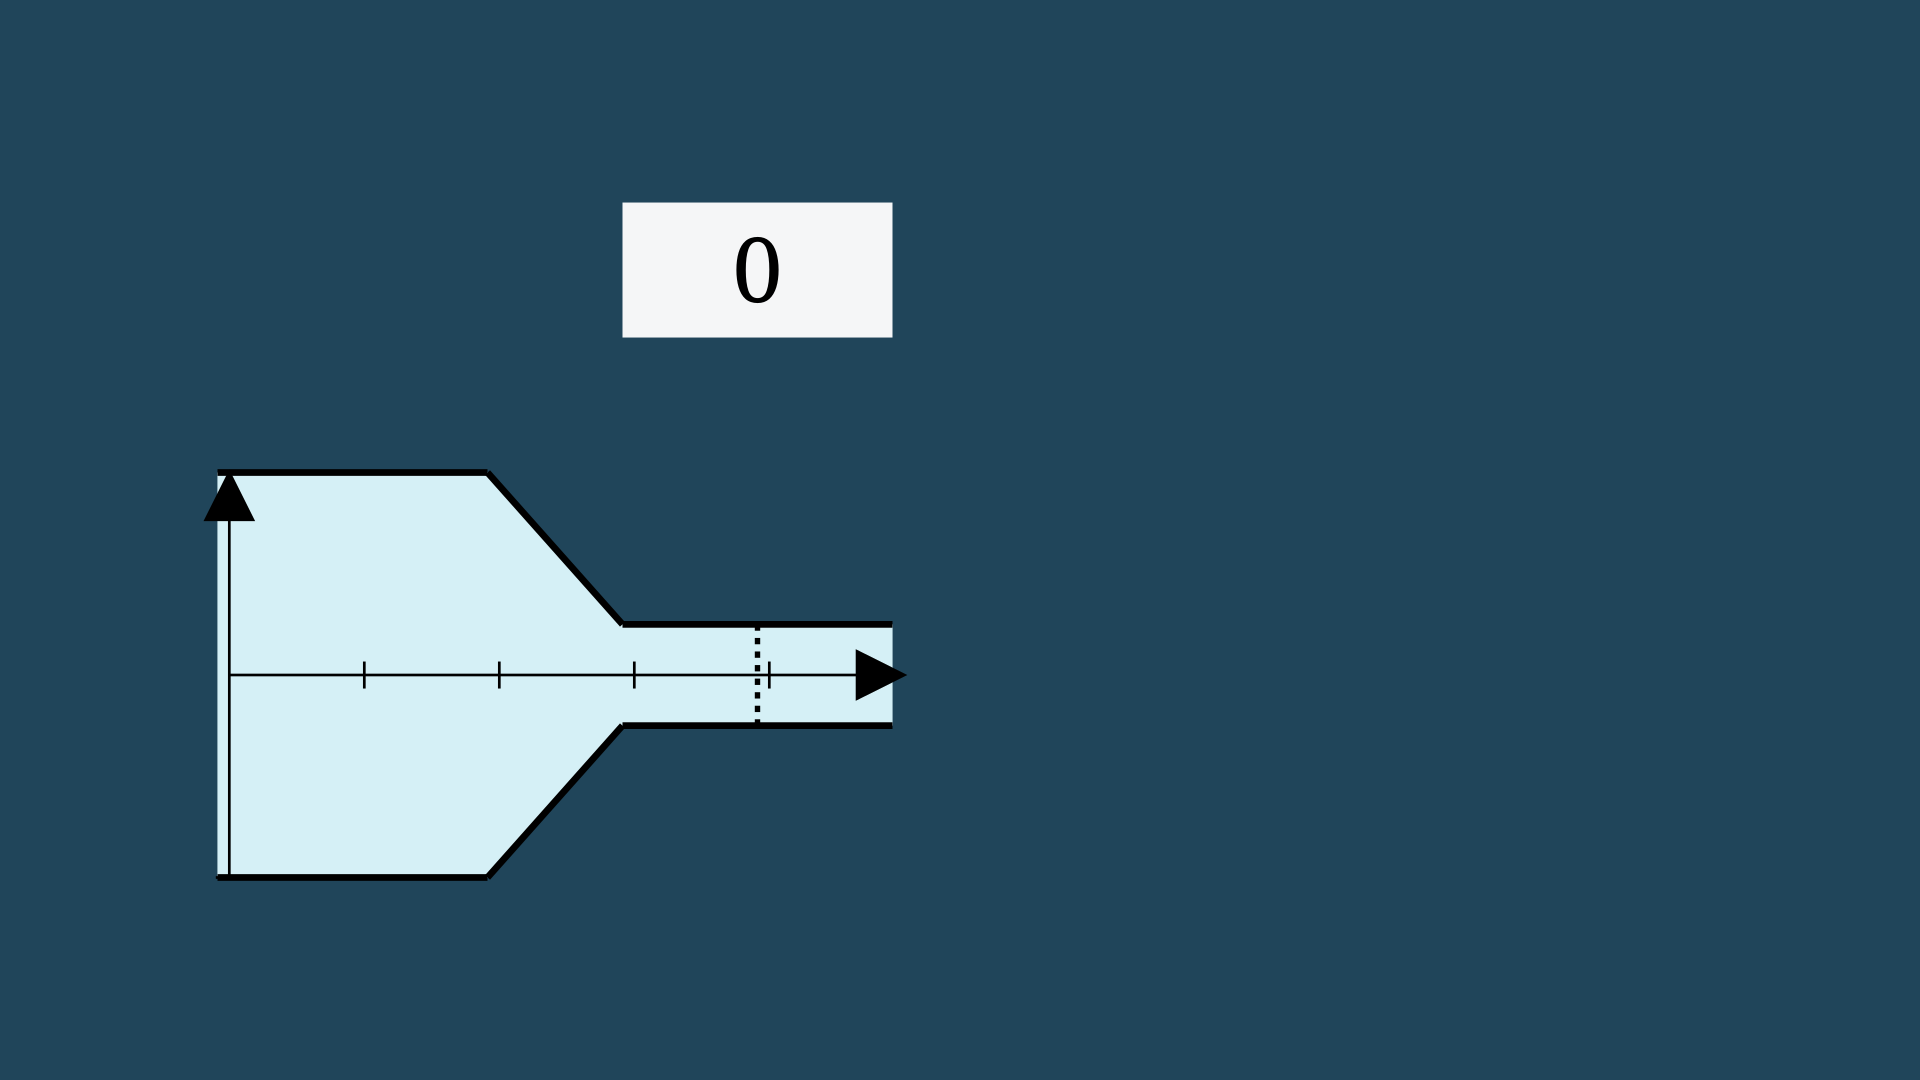

In [125]:
%%manim -qh --fps 60 $video_scene


class ndw_bernoulli_Scene(Scene):
    def construct(self):
        self.camera.background_color = background_color


        # bernoulli tube
        bernoulli_tube = BernoulliTube(tube_center = np.array([-3, -1, 0]), tube_stroke_color = BLACK)
        self.add(bernoulli_tube)

        bernoulli_tube_counter = bernoulli_tube.get_counter()
        self.add(bernoulli_tube_counter)


        # hallway with door
        